Function of interest

In [211]:
import torch
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
torch.set_default_tensor_type(torch.DoubleTensor)

device = 'cpu'

In [212]:
# def phi(y):
#     # return 0.25 * (1.0 + 0.5 * x ** 2 + 0.1 * (x)**4 - 0.5 * np.cos(5 * np.pi * x) - 0.1 * np.cos(50 * x))
#     x = torch.sum(y,dim=1)
#     return  0.1 + 0.05 * (2.5 + torch.sin(10.0 * np.pi * x) / ( 2.0 * x) + (x - 1.0) ** 4)

# def phi(y):
#     # assume size of y is n_samples x 1
#     alpha = 0.5
#     abs_y = torch.abs(y)**alpha
#     # return torch.sum(abs_y,dim=1)**(1/alpha)
#     return torch.sum(abs_y,dim=1)

def phi(y, n_terms=100):
    # assume size of y is n_samples x 1
    # code the Weierstrass function as a pytorch function
    # y is a n_samples x 1 tensor

    a, b = 0.3, 23
    f = 0.0
    assert a*b > 1 + 3 * np.pi / 2

    for k in range(n_terms):
        term = a**k * torch.cos(b**k * np.pi * y)
        f += term
    return f


In [213]:
def get_inf_convolution_1D(phi, delta, domain, int_samples, alpha=1, linesearch_iters=0):
  # Compute global minimum of phi using self-normalized inf-convolution formula

  linesearch_iters +=1

  # n_inputs = xt.shape[0]

  y = (domain[1]-domain[0])*torch.rand(int_samples,1, device=device) + domain[0]

  argmin_output = torch.zeros(1, device=device)
  min_output = torch.zeros(1, device=device)

  # both values below are of size n_samples
  phi_val = phi(y)

  z = -(phi_val)/delta # shape =  n_samples
  w = torch.softmax(z, dim=0) # shape = n_samples

  softmax_overflow_check = (w < np.inf)

  if softmax_overflow_check.prod()==0.0:
    print('z = ', z)
    print('w = ', w)
    alpha = 0.5*alpha
    return get_inf_convolution_1D(phi, delta, domain, int_samples, alpha=alpha, linesearch_iters=linesearch_iters)
  else:
    argmin_term = torch.matmul(w.t(), y)
    argmin_term = argmin_term.view(-1,1)

    argmin_overflow = (argmin_term < np.inf)
    if argmin_overflow.prod() == 0.0:
      print('argmin_term overflowed: ', argmin_term)
    assert(argmin_overflow.prod() == 1.0)

    min_output = phi(argmin_term.view(1,-1)) 
    argmin_output = argmin_term.view(1,-1)

  return min_output, argmin_output, linesearch_iters

In [214]:
int_samples = int(1e3)

domain = [-2,2]
# domain = [-1,2]
delta = 1e-6

# evaluate infimal convolution
min_output, argmin_output, linesearch_iters = get_inf_convolution_1D(phi, delta, domain, int_samples, alpha=1, linesearch_iters=0)

<Figure size 640x480 with 0 Axes>

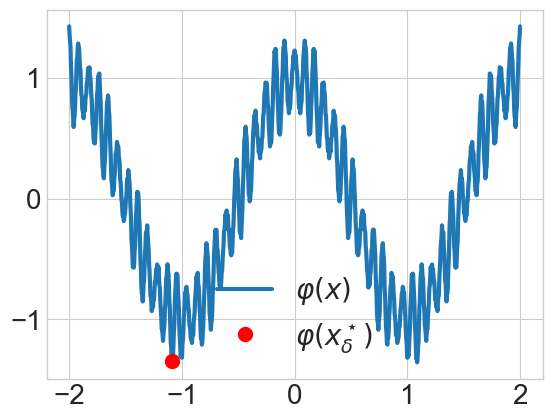

In [215]:
# plotting parameters
title_fontsize = 22
fontsize       = 20
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

fig1 = plt.figure()
plt.style.use('seaborn-v0_8-whitegrid')
ax = plt.axes()

f_star = 0.0

x = torch.linspace(domain[0],domain[1],1000)
y = phi(x.view(-1,1))
ax.plot(x, y, linewidth=3, color=my_blue)
ax.plot(argmin_output, min_output, 'o', markersize=10, color='red')

# fig1.set_figwidth(5.5)
# fig1.set_figheight(5.4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
legend_str1 = r'$\varphi(x)$'
legend_str2 = r'$\varphi(x_\delta^\star)$'
# add legend in bottom right
ax.legend([legend_str1, legend_str2],fontsize=fontsize, loc='best')
# ax.legend([legend_str1, legend_str2],fontsize=fontsize, loc='best', bbox_to_anchor=(0.5, 1.05))
ax.tick_params(labelsize=fontsize, which='both', direction='in')
# save_str = '1d_exp_images/1D_smooth_nonconvex.pdf'
# save_str = '1d_exp_images/1D_nonsmooth_nonconvex.pdf'
# save_str = '1d_exp_images/1D_Weierstrass.pdf'
# fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [216]:
# save the tensor tables to CSV files
import csv

# save_str_csv = '1D_nonsmooth_nonconvex.csv'
# save_str_csv = '1D_smooth_nonconvex.csv'
save_str_csv = '1D_Weierstrass.csv'

data = torch.cat([x.view(-1,1), y.view(-1,1)], dim=1)
data = data.tolist()

with open(save_str_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    # writer.writerows(data)

    for row in data:
        writer.writerow(row)

print(f"Tensor saved to {save_str_csv}")

# save_str_csv2 = '1D_nonsmooth_nonconvex_argmin.csv'
# save_str_csv2 = '1D_smooth_nonconvex_argmin.csv'
save_str_csv2 = '1D_Weierstrass_argmin.csv'

data2 = torch.cat([argmin_output.view(-1,1), min_output.view(-1,1)], dim=1)
data2 = data2.tolist()

with open(save_str_csv2, 'w', newline='') as file:
    writer = csv.writer(file)
    # writer.writerows(data2)

    for row in data2:
        writer.writerow(row)

print(f"Tensor saved to {save_str_csv2}")

Tensor saved to 1D_Weierstrass.csv
Tensor saved to 1D_Weierstrass_argmin.csv
